You'll find notebooks relative to feature engineering and data prep  in ../data_prep/

## Modeling

In [148]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
import numpy as np

import seaborn as sns


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer
import warnings
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline 

In [149]:
def evaluate_model(clf, X_train, y_train, X_test, y_test):    
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)


    return(confusion_matrix(y_test, y_pred))
 


def cross_val(clf, X, y, k = 10):
    scores = cross_val_score(clf, X, y, cv = k , verbose = 1)
    return(scores)

In [150]:
def importance_feature(X, forest):
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("{}. feature {} ({})".format(f + 1, X.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [151]:
categorical_features = pickle.load(open( "../../../data/var_category.p", "rb" ))
numeric_features = pickle.load(open( "../../../data/var_continuous.p", "rb" ))

### Pipeline

In [152]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
 
    ('transformation', PowerTransformer()),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [153]:
clf_names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = {
    "KNN" : KNeighborsClassifier(3),
    "LinearSVM" : SVC(kernel="linear", C=0.025),
    "Gaussian Process Classifier" : GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision tree classifier" : DecisionTreeClassifier(max_depth=5),
    "Random Forest Classifier" : RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "MLP Classifier" : MLPClassifier(alpha=1),
    "AdaBoost Classifier" : AdaBoostClassifier(),
    "GaussianNB" : GaussianNB(),
    "QDA" : QuadraticDiscriminantAnalysis() 
}

In [154]:
X = pd.read_csv('../../../data/X.csv')
y = pd.read_csv('../../../data/y.csv')

X = X[categorical_features + numeric_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scores = list()
evaluate_m = dict()

for clf in classifiers.keys() :
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifiers[clf])])
    scores.append(cross_val(pipe, X, y, k = 10))
    evaluate_m[clf] = evaluate_model(classifiers[clf], X_train, y_train, X_test, y_test)

scores = pd.DataFrame(scores).T
scores.columns = classifiers.keys()
    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [163]:
scores.mean().sort_values()

GaussianNB                     0.153938
MLP Classifier                 0.793040
AdaBoost Classifier            0.797802
Decision tree classifier       0.813462
KNN                            0.851923
QDA                            0.853205
Random Forest Classifier       0.875733
Gaussian Process Classifier    0.882875
LinearSVM                      0.882875
dtype: float64

In [158]:
forest = classifiers["Random Forest Classifier"]

def plot_feat_imp(X, forest) : 
    
    sns.set_style("dark")
    sns.set_palette(sns.color_palette("GnBu_d"))

    feature_importance = pd.DataFrame(data = {'feature_importance' : forest.feature_importances_, 'feature_name' : X.columns})
    feature_importance = feature_importance.sort_values('feature_importance', ascending = False).loc[0:25]
    ax = sns.barplot(x="feature_name", y="feature_importance", data=feature_importance)
    plt.xticks(rotation=90)


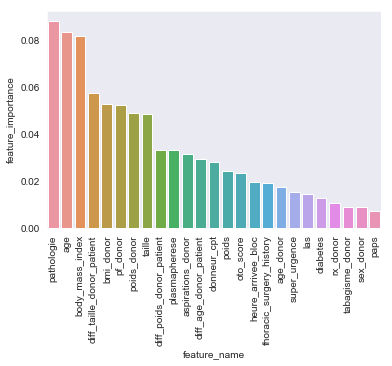

In [159]:
plot_feat_imp(X,forest)

## Shap


In [164]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = forest
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

[14:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[14:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_

In [165]:
explainer.expected_value

0.53688097

In [166]:
explainer.expected_value

0.53688097

The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

In [169]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[100,:])


In [21]:
shap.force_plot(explainer.expected_value, shap_values, X)

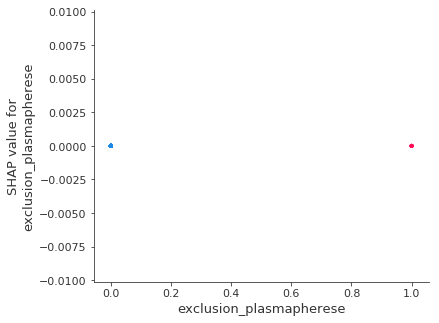

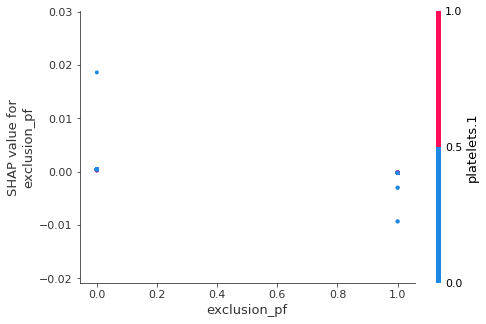

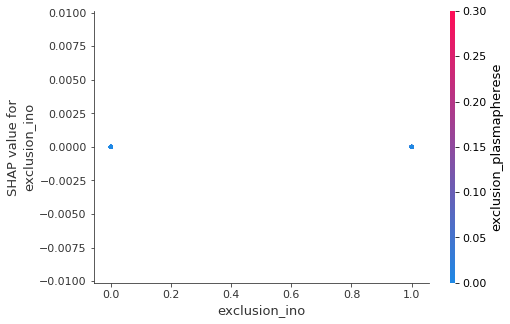

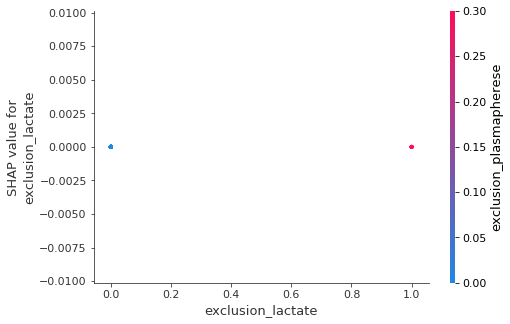

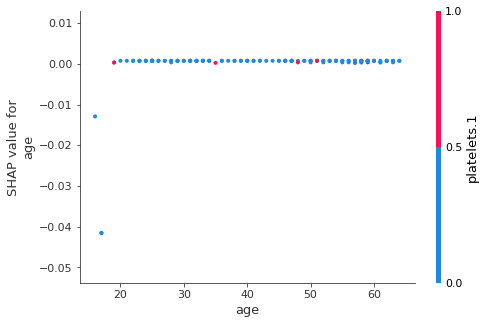

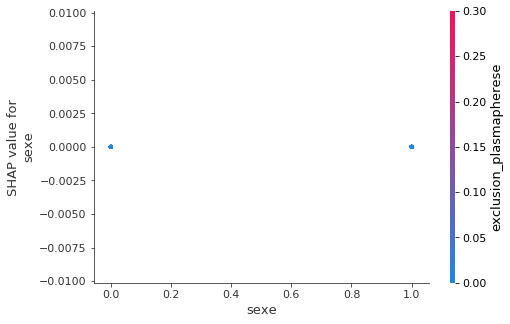

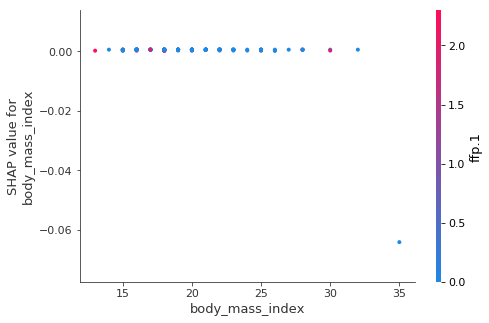

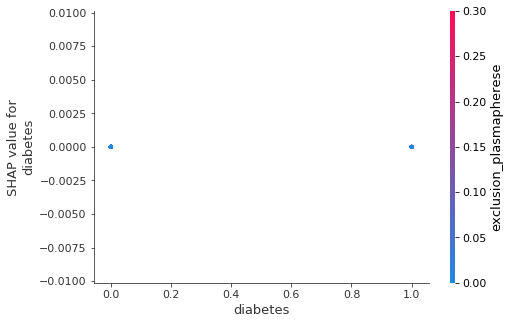

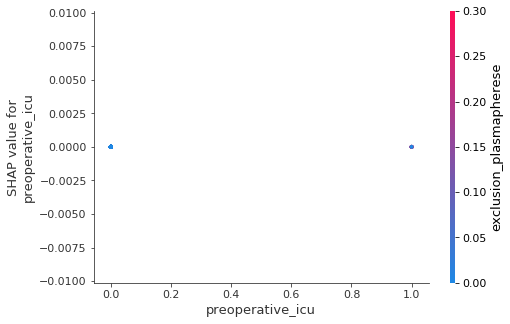

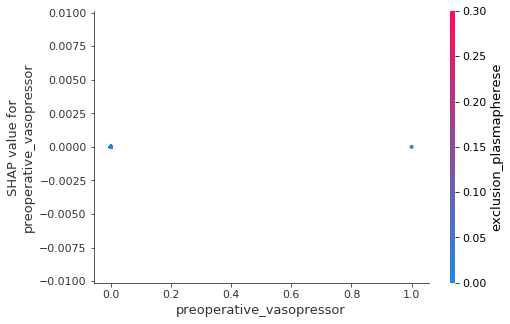

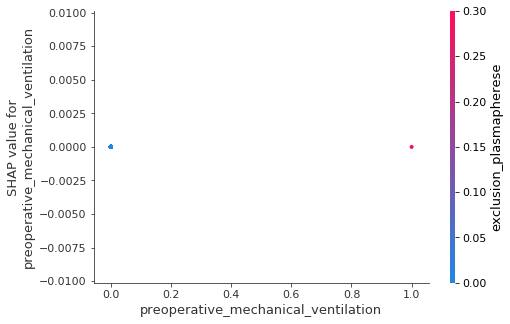

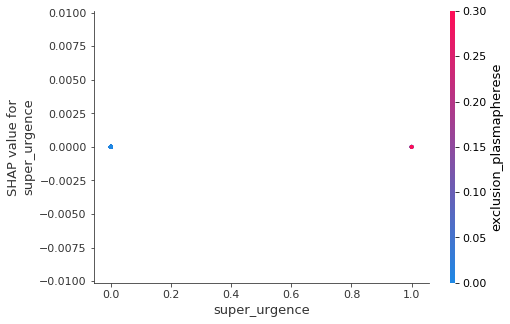

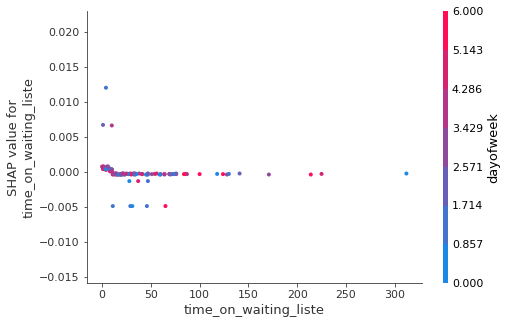

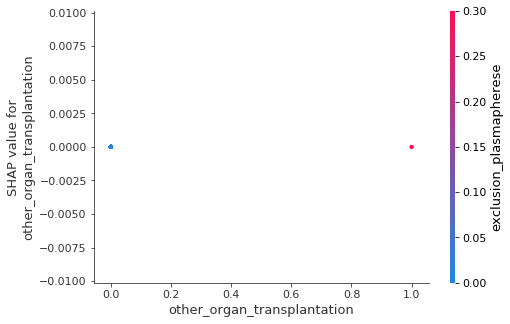

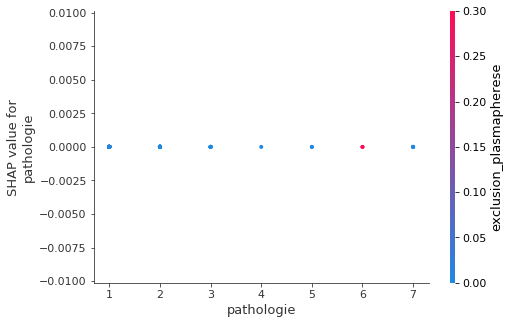

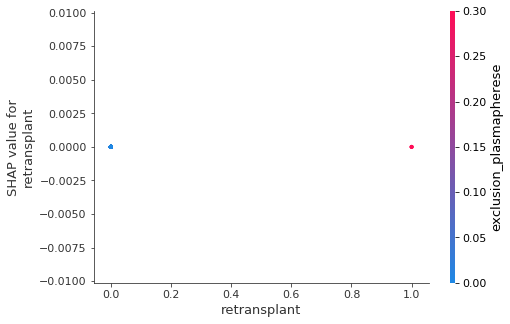

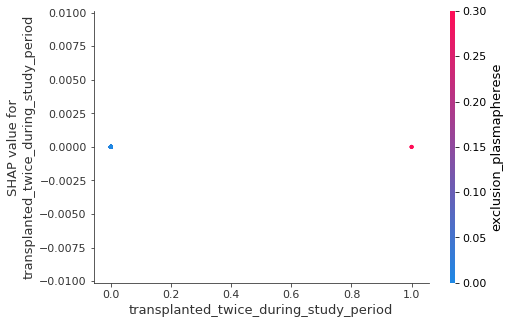

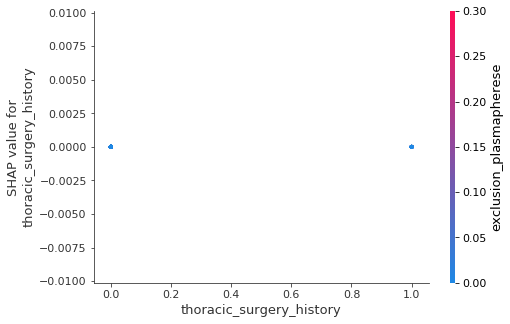

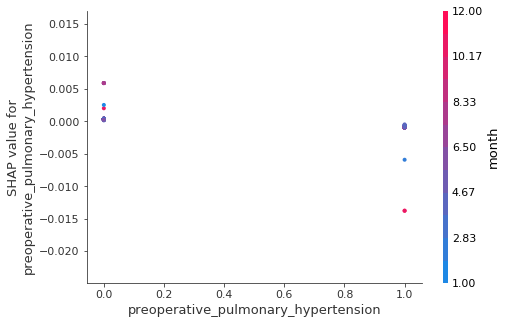

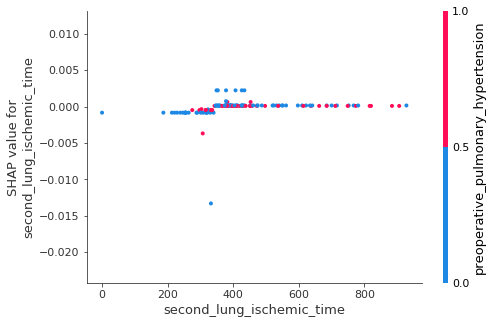

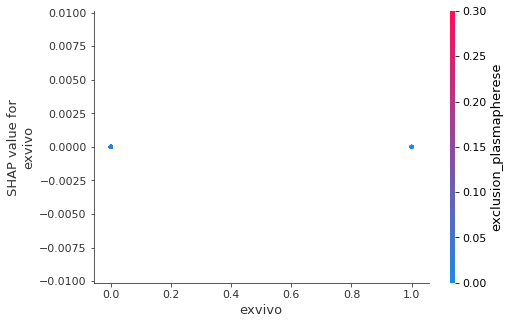

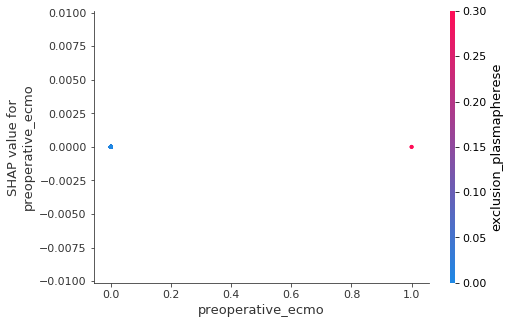

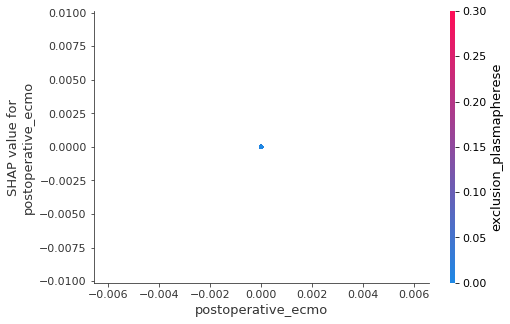

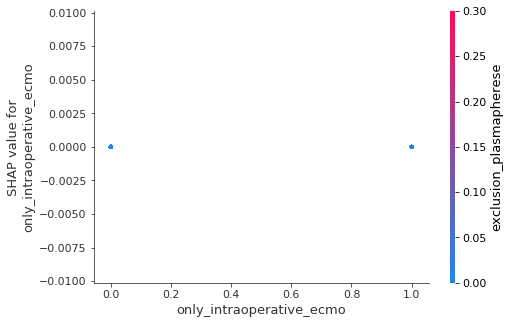

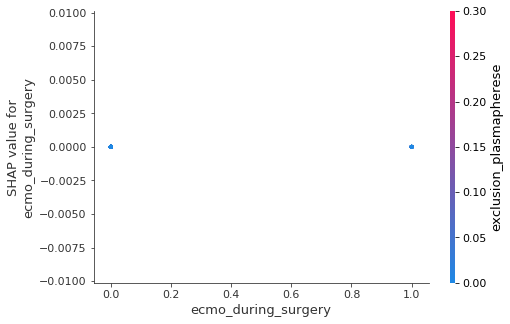

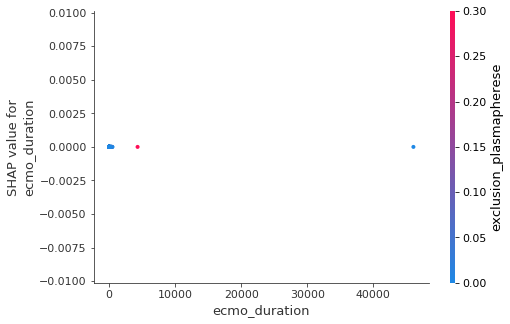

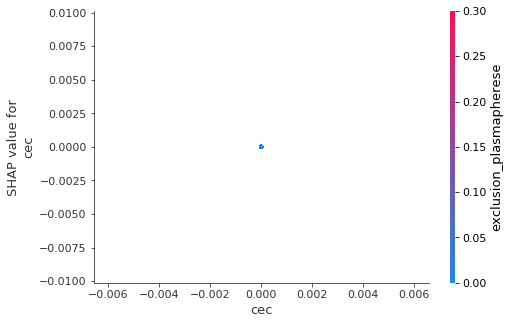

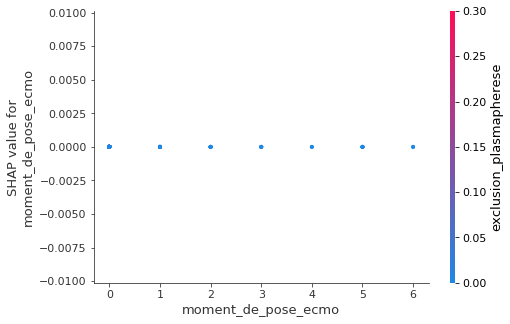

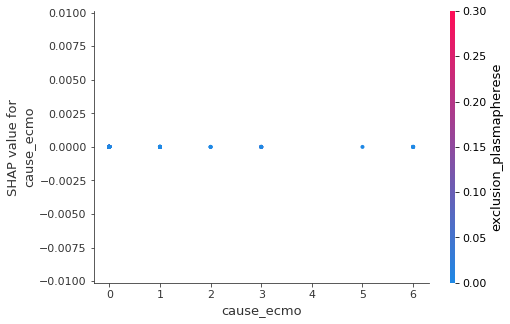

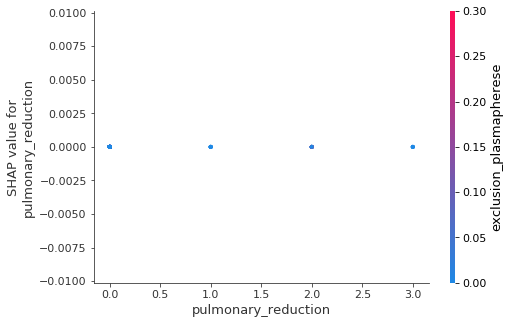

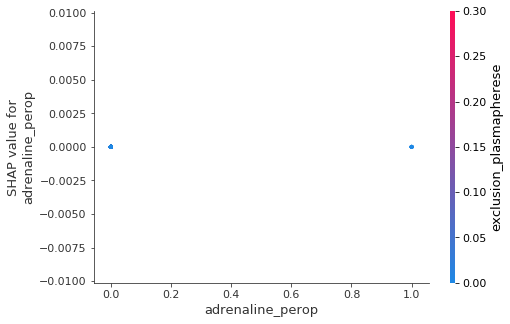

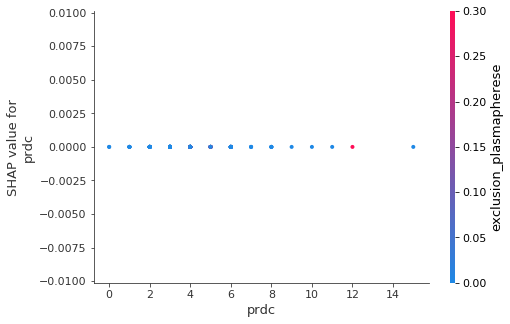

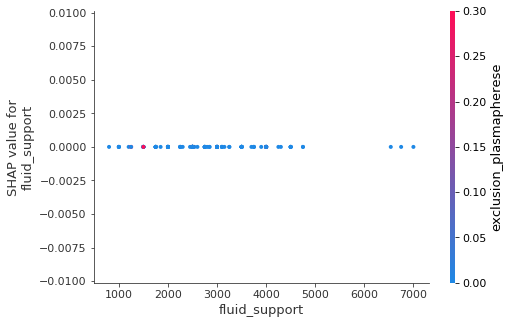

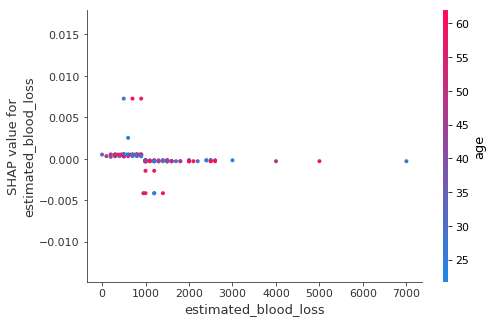

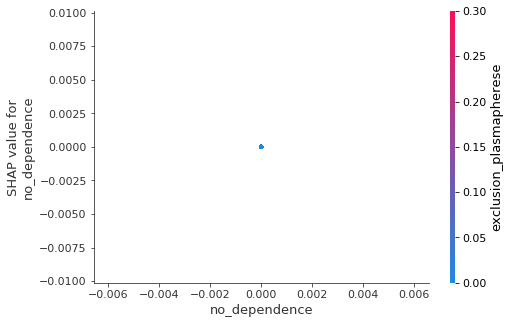

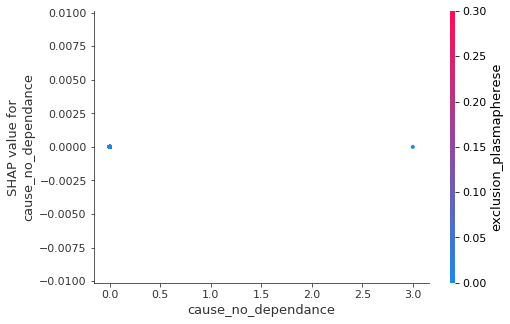

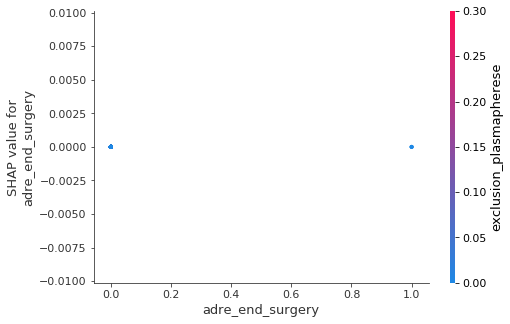

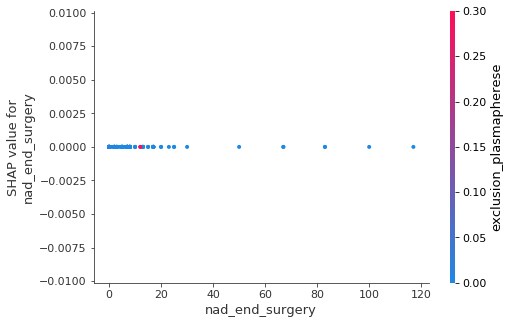

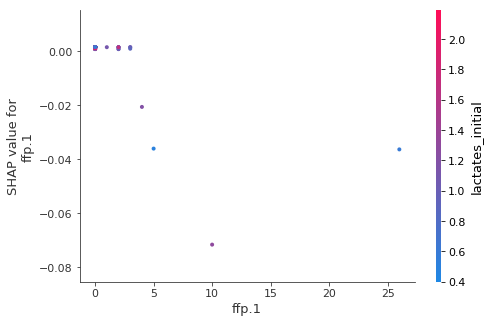

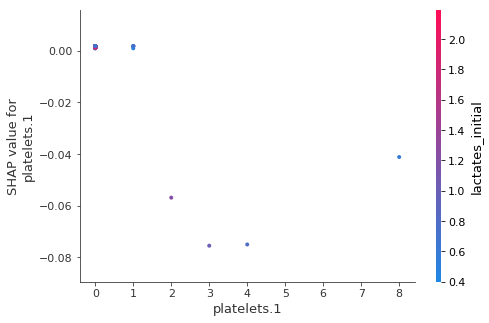

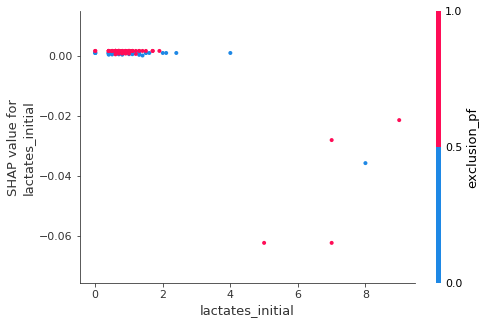

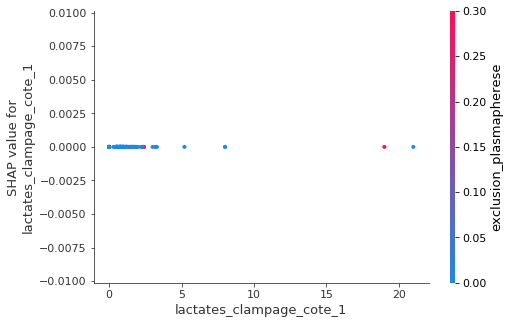

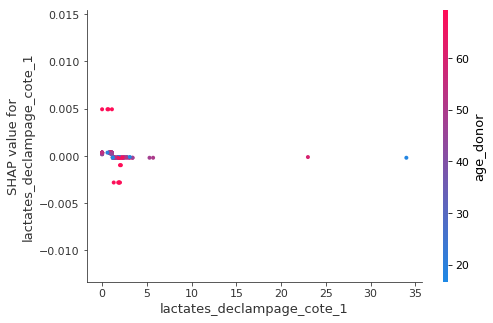

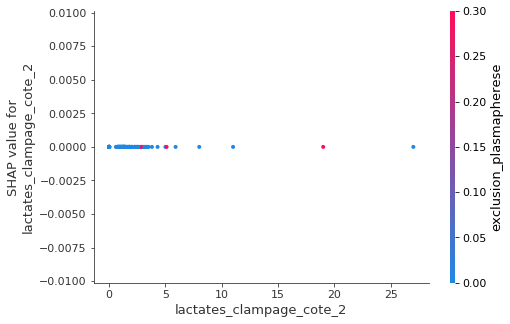

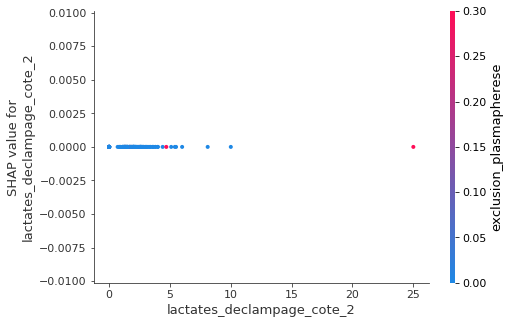

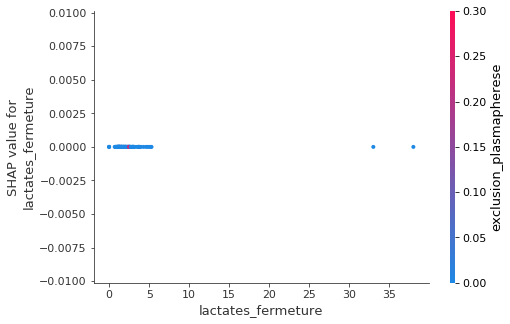

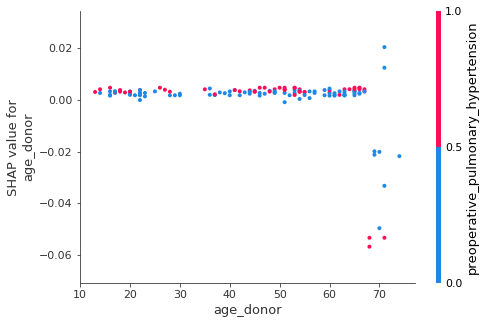

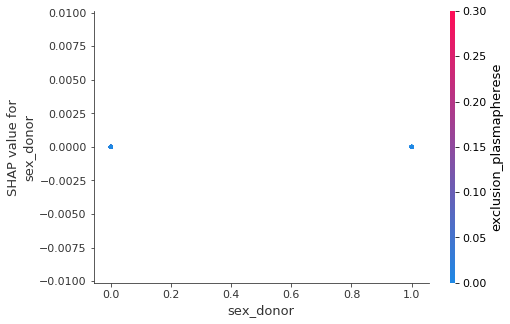

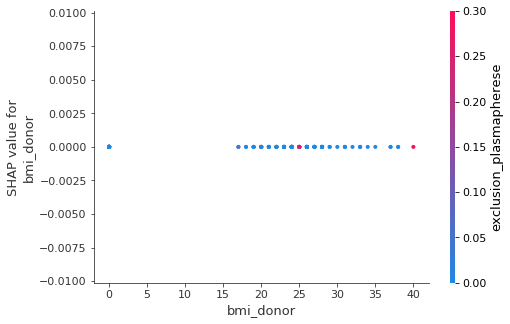

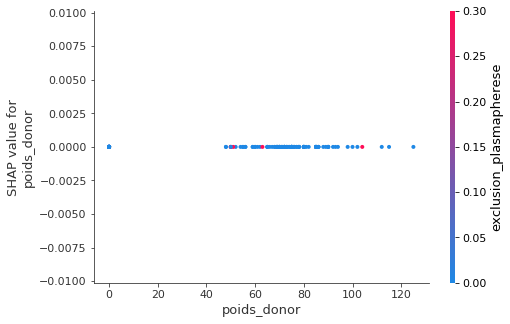

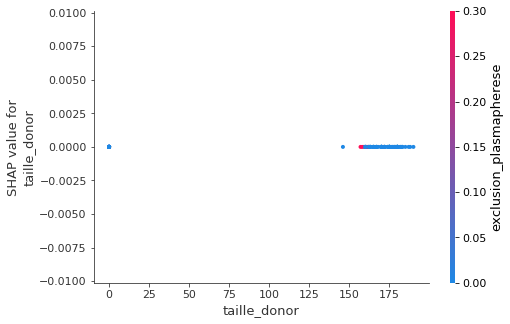

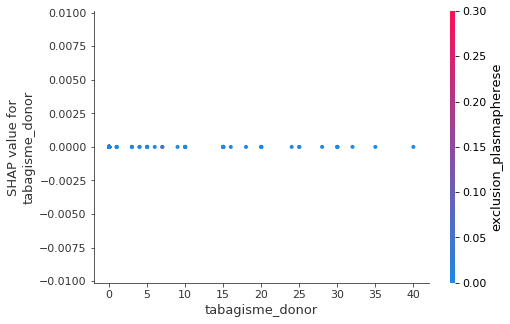

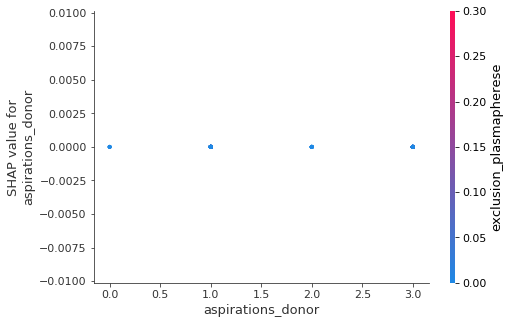

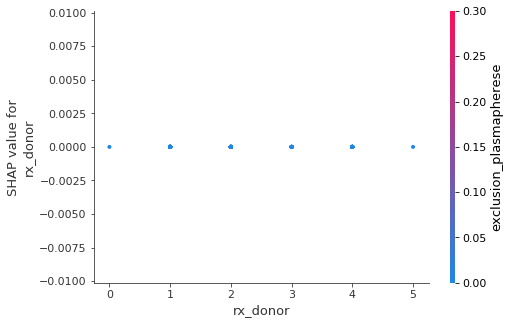

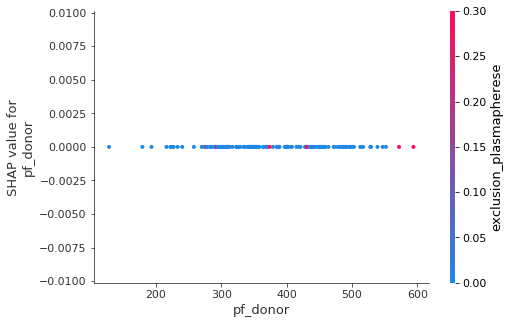

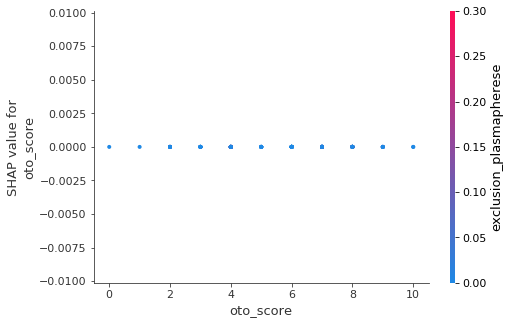

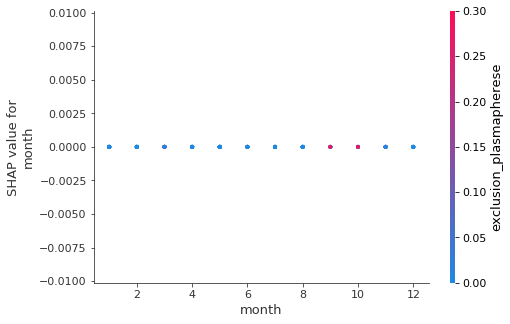

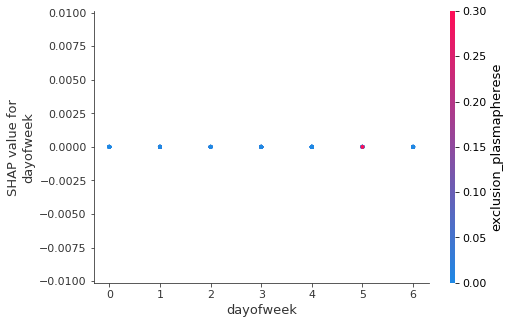

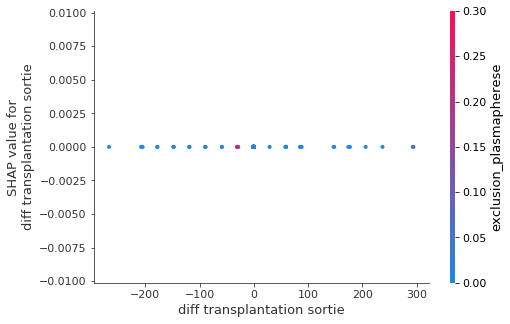

In [22]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
for col in X.columns : 
    shap.dependence_plot(col, shap_values, X)


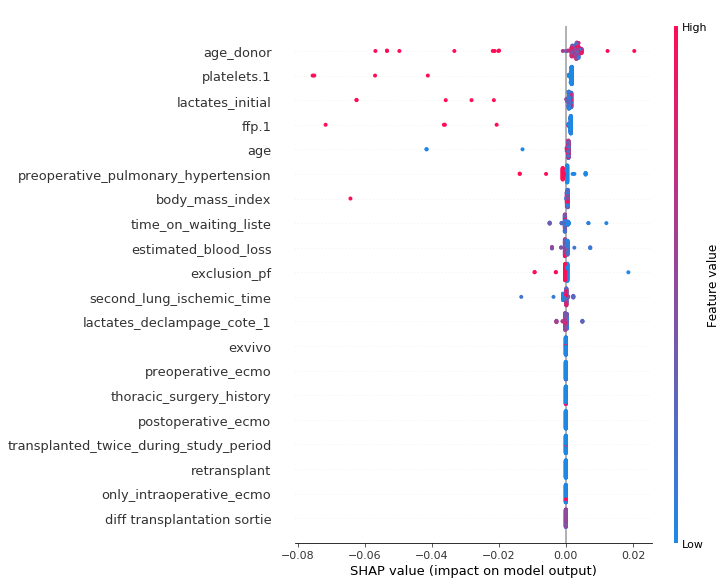

In [23]:
shap.summary_plot(shap_values, X)

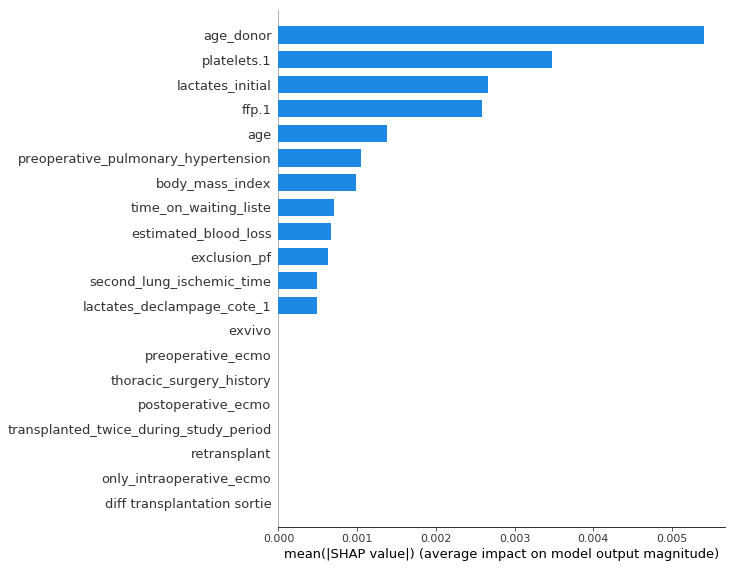

In [24]:
shap.summary_plot(shap_values, X, plot_type="bar")

ValueError: min() arg is an empty sequence

### Oneclass SVM Draft

In [ ]:
X_scope = X[y == 1]
y_scope = X[y == 1]

X_out = X[y == 0]

In [ ]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [ ]:
clf.fit(X_scope, y_scope)
y_pred = clf.predict(X_out)

print("accuracy : {}, on {}".format((y_pred == -1).sum()/len(y_pred), len(y_pred)))

y_pred = clf.predict(X_scope)
print("accuracy : {}, on {}".format((y_pred == 1).sum()/len(y_pred), len(y_pred)))


In [ ]:
clf.fit(X_scope, y_scope)
y_pred = clf.predict(X_out)

print("accuracy : {}, on {}".format((y_pred == -1).sum()/len(y_pred), len(y_pred)))

y_pred = clf.predict(X_scope)
print("accuracy : {}, on {}".format((y_pred == 1).sum()/len(y_pred), len(y_pred)))


In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

sne = TSNE(n_components=2)
tsne_result = sne.fit_transform(X)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)


In [ ]:
tsne_df = pd.DataFrame(tsne_result_scaled)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

In [ ]:
X_train = tsne_df[y == 1]
X_test = tsne_df[y == 1]

X_outliers = tsne_df[y == 0]

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm


clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)


In [ ]:
def make_meshgrid(x, y, h=.02) :
    
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params) :
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)

    return out


In [ ]:
fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = tsne_df[0], tsne_df[1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)